In [1]:
# our commonly used functions
from global_bug_bot_functions import  *


# libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2


# utility libraries
import os
import time
import itertools
import random
import numpy as np



# Set random seeds for reproducibility
seed_value = 2025
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# data set constants
TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR, shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(VALID_DIR, shuffle_flag=False)

# best hps found from tuning
# from ep20_pat3_del0.001_ex1_maxtr20_from_tuning_script_final_tuned_models_results_MobileNetV2.csv
# ---> tuned with max epoch = 20, patience = 3, minimum delta = 0.001, max trials = 20
best_lr = 0.001
best_dropout = 0.2
best_batch_size	= 64
best_epochs	= 15


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the base model layers
base_model.trainable = False

# global pooling and dropout layers included similar to jute pest architecture
x = BatchNormalization()(base_model.output) # JUST ADDED
x = Dropout(best_dropout)(x) # JUST ADDED
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(best_dropout)(x)
x = BatchNormalization()(x) # JUST ADDED

# final softmax probabilistic classification layer - JUST ADDED L2
output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax', kernel_regularizer=l2(0.05))(x)
model = Model(inputs=base_model.input, outputs=output_layer)

optimizer = Adam(learning_rate=best_lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# JUST ADDED: get init accuracy before training
initial_loss_val, initial_accuracy_val = model.evaluate(VAL_GENERATOR)
initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)

print("Metrics Before Training:")
print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
print(f" - Validation -> Loss: {initial_loss_val:.4f}, Accuracy: {initial_accuracy_val:.4f}")

history = model.fit(TRAIN_GENERATOR,validation_data=VAL_GENERATOR, epochs = best_epochs, batch_size = best_batch_size)

# append intial values for plotting
history.history['accuracy'].insert(0, initial_accuracy_train) #training
history.history['loss'].insert(0, initial_loss_train)  # training

history.history['val_accuracy'].insert(0, initial_accuracy_val)  # validation
history.history['val_loss'].insert(0, initial_loss_val)  # validation




Found 6090 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.


/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.0842 - loss: 4.1590 
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.0871 - loss: 4.1409
Metrics Before Training:
 - Training   -> Loss: 4.1253, Accuracy: 0.0885
 - Validation -> Loss: 4.1272, Accuracy: 0.0818
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - accuracy: 0.4674 - loss: 2.6044 - val_accuracy: 0.6432 - val_loss: 1.6094
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.8058 - loss: 1.1163 - val_accuracy: 0.6955 - val_loss: 1.3331
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step - accuracy: 0.8516 - loss: 0.8541 - val_accuracy: 0.6864 - val_loss: 1.2580
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.8746 - loss: 0.7737 - val_accuracy: 0.6727 - val_loss: 1.2638
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.8662 - loss: 0.7689 - val_accuracy: 0.6523 - val_loss: 1.2432
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.8

# Validation plots

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.756098,0.775000,0.765432,40.000000
american_house_spider,0.658537,0.675000,0.666667,40.000000
bedbug,0.666667,0.700000,0.682927,40.000000
brown_stink_bug,0.787879,0.650000,0.712329,40.000000
carpenter_ant,0.581395,0.625000,0.602410,40.000000
cellar_spider,0.857143,0.750000,0.800000,40.000000
flea,0.377049,0.575000,0.455446,40.000000
house_centipede,0.857143,0.750000,0.800000,40.000000
silverfish,0.750000,0.675000,0.710526,40.000000
subterranean_termite,0.588235,0.500000,0.540541,40.000000


<Figure size 800x600 with 0 Axes>

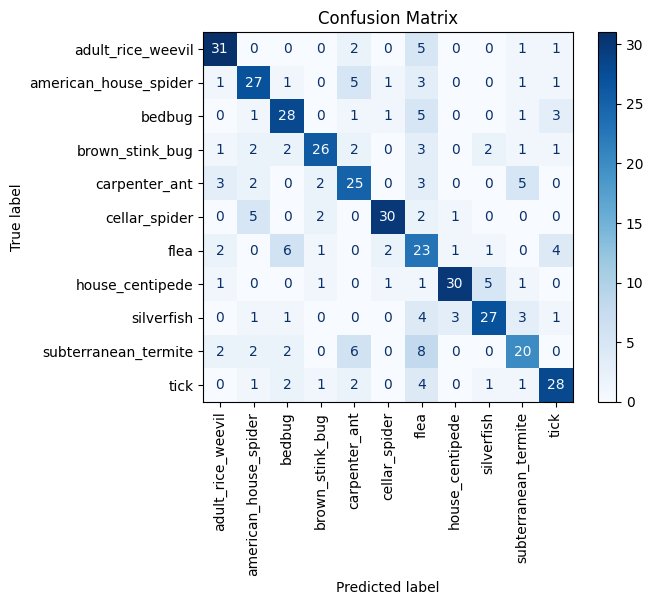

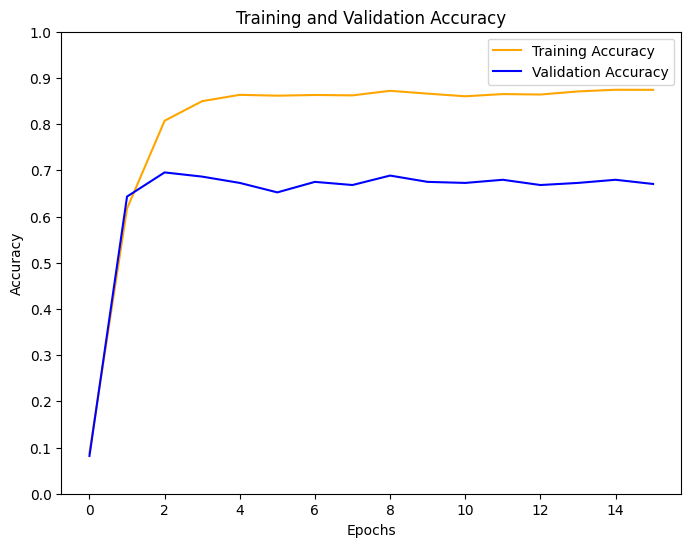

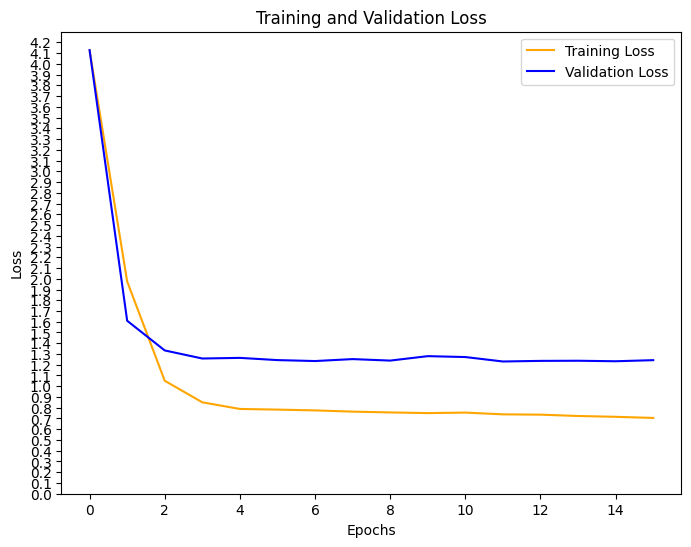

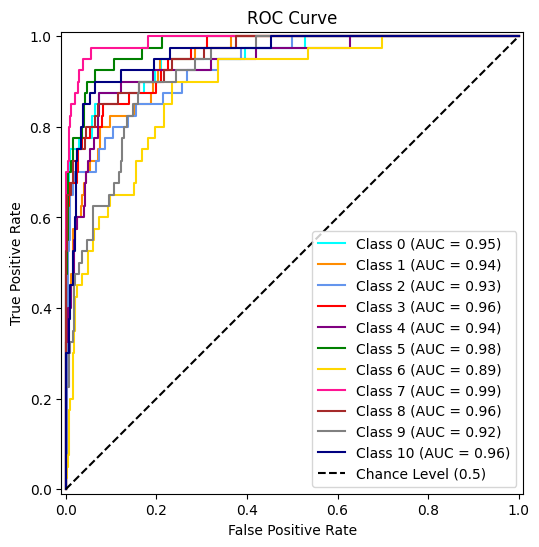

Macro-averaged One-vs-Rest ROC AUC score: 0.95
Accuracy: 0.670
Precision: 0.691
Recall: 0.67
F1 Score: 0.677


{'accuracy': 0.67,
 'precision': 0.691,
 'recall': 0.67,
 'f1_score': 0.677,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.756098  0.775000  0.765432   40.000000
 american_house_spider   0.658537  0.675000  0.666667   40.000000
 bedbug                  0.666667  0.700000  0.682927   40.000000
 brown_stink_bug         0.787879  0.650000  0.712329   40.000000
 carpenter_ant           0.581395  0.625000  0.602410   40.000000
 cellar_spider           0.857143  0.750000  0.800000   40.000000
 flea                    0.377049  0.575000  0.455446   40.000000
 house_centipede         0.857143  0.750000  0.800000   40.000000
 silverfish              0.750000  0.675000  0.710526   40.000000
 subterranean_termite    0.588235  0.500000  0.540541   40.000000
 tick                    0.717949  0.700000  0.708861   40.000000
 accuracy                0.670455  0.670455  0.670455    0.670455
 macro avg               0.690736  0.

In [2]:
%matplotlib inline
evaluation_metrics(model, EVAL_VAL_GENERATOR, history)


# Validation metrics: 'accuracy': 0.675,'precision': 0.693,'recall': 0.675,'f1_score': 0.679

# Test plots

/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.700000,0.700000,0.700000,20.000000
american_house_spider,0.941176,0.800000,0.864865,20.000000
bedbug,0.450000,0.450000,0.450000,20.000000
brown_stink_bug,0.760000,0.950000,0.844444,20.000000
carpenter_ant,0.722222,0.650000,0.684211,20.000000
cellar_spider,0.933333,0.700000,0.800000,20.000000
flea,0.378378,0.700000,0.491228,20.000000
house_centipede,0.947368,0.900000,0.923077,20.000000
silverfish,1.000000,0.700000,0.823529,20.000000
subterranean_termite,0.700000,0.700000,0.700000,20.000000


<Figure size 800x600 with 0 Axes>

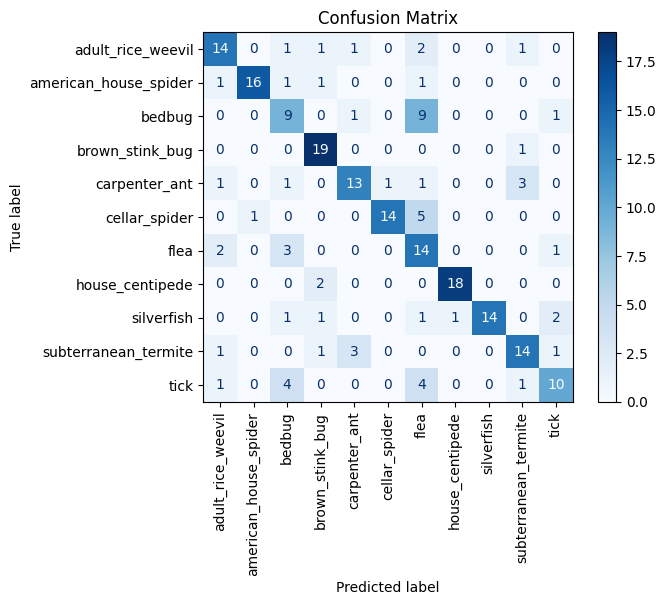

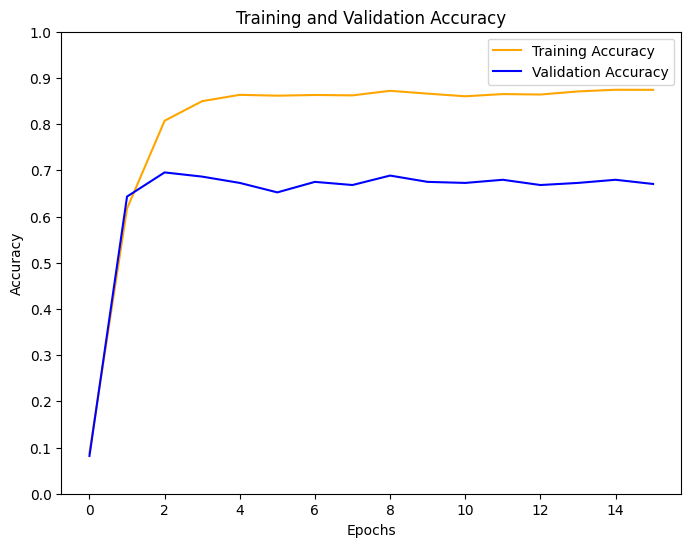

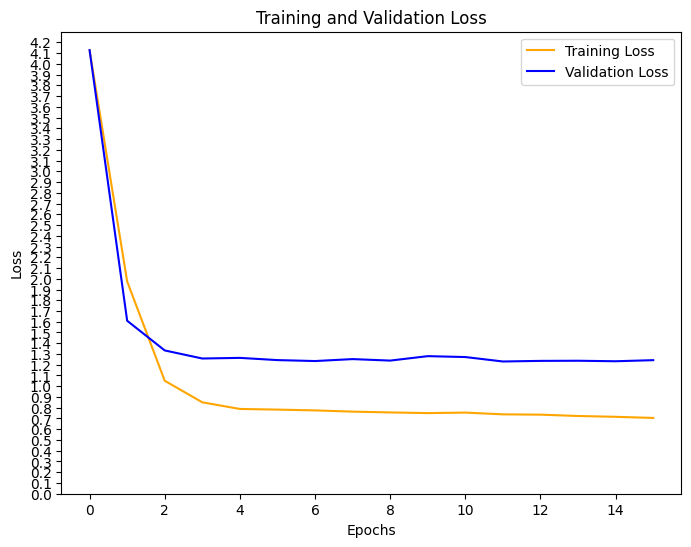

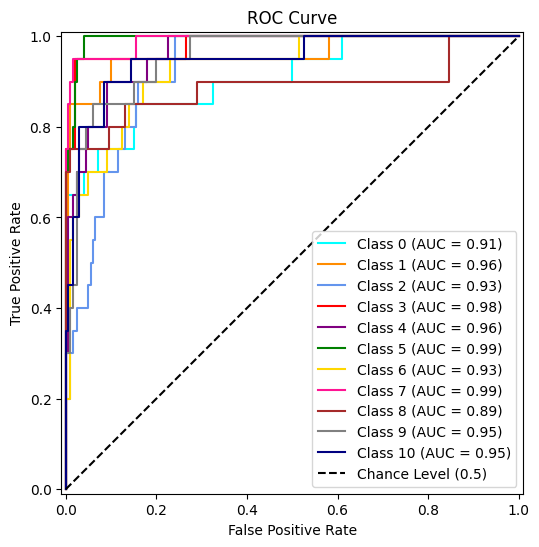

Macro-averaged One-vs-Rest ROC AUC score: 0.95
Accuracy: 0.705
Precision: 0.745
Recall: 0.705
F1 Score: 0.714


{'accuracy': 0.705,
 'precision': 0.745,
 'recall': 0.705,
 'f1_score': 0.714,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.700000  0.700000  0.700000   20.000000
 american_house_spider   0.941176  0.800000  0.864865   20.000000
 bedbug                  0.450000  0.450000  0.450000   20.000000
 brown_stink_bug         0.760000  0.950000  0.844444   20.000000
 carpenter_ant           0.722222  0.650000  0.684211   20.000000
 cellar_spider           0.933333  0.700000  0.800000   20.000000
 flea                    0.378378  0.700000  0.491228   20.000000
 house_centipede         0.947368  0.900000  0.923077   20.000000
 silverfish              1.000000  0.700000  0.823529   20.000000
 subterranean_termite    0.700000  0.700000  0.700000   20.000000
 tick                    0.666667  0.500000  0.571429   20.000000
 accuracy                0.704545  0.704545  0.704545    0.704545
 macro avg               0.745377  

In [3]:
%matplotlib inline
evaluation_metrics(model, TEST_GENERATOR, history)


# Test metrics: 'accuracy': 0.732, 'precision': 0.747,'recall': 0.732, 'f1_score': 0.735